In [1]:
#install pyreadr on terminal
! pip install pyreadr lightgbm

     |████████████████████████████████| 364 kB 24.0 MB/s            
     |████████████████████████████████| 2.0 MB 48.9 MB/s            
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import os
from termcolor import colored

from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.metrics import confusion_matrix,precision_recall_curve, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score, roc_auc_score

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier 
from sklearn.ensemble import BaggingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC,SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN

# Haplotype model - Categorical variable

In [3]:
import pyreadr

# read in female data
result = pyreadr.read_r('/mnt/ML_HBLUP/NA_RM105_110_115/data/dummyMatrix_female.rds') # also works for RData
# done! 
# result is a dictionary where keys are the name of objects and the values python
# objects. In the case of Rds there is only one object with None as key
femaleData = result[None] # extract the pandas data frame 

# read in male data
result = pyreadr.read_r('/mnt/ML_HBLUP/NA_RM105_110_115/data/dummyMatrix_male.rds') # also works for RData
maleData = result[None] # extract the pandas data frame 

In [4]:
femaleData.head()

,HB1__1067-1,HB1__32843,HB1__64DWA2,HB1__B73,HB1__MANS,HB1__NA,HB1__WDAQ2,HB2__1067-1,HB2__32843,HB2__64DWA2,...,HB17115__7797,HB17115__B73,HB17115__NA,HB17115__RQAA8,HB17116__2FACC,HB17116__7797,HB17116__B73,HB17116__FBMU,HB17116__NA,HB17116__RQAA8
01DHD10,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
01DHD16,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
01DKD2-BGL-T1A1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
01DKD2-NQR-T1B1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
01DKD2,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [5]:
maleData.head()

,HB1__01HGI4,HB1__610,HB1__B14,HB1__LH287,HB1__M3AG-3,HB1__NA,HB1__OH43AE1,HB1__PH207,HB2__610,HB2__B14,...,HB17114__OH07,HB17114__PH207,HB17115__LH123,HB17115__NA,HB17115__OH07,HB17115__TA1180,HB17116__LH123,HB17116__NA,HB17116__OH07,HB17116__PH207
LH287,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0
83INI14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
17IFI6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
DILU757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GEJO564,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [6]:
# add suffix
femaleData.columns += '_f'
maleData.columns += '_m'

In [7]:
maleData.head()

,HB1__01HGI4_m,HB1__610_m,HB1__B14_m,HB1__LH287_m,HB1__M3AG-3_m,HB1__NA_m,HB1__OH43AE1_m,HB1__PH207_m,HB2__610_m,HB2__B14_m,...,HB17114__OH07_m,HB17114__PH207_m,HB17115__LH123_m,HB17115__NA_m,HB17115__OH07_m,HB17115__TA1180_m,HB17116__LH123_m,HB17116__NA_m,HB17116__OH07_m,HB17116__PH207_m
LH287,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0
83INI14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
17IFI6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
DILU757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GEJO564,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [8]:
femaleData.head()

,HB1__1067-1_f,HB1__32843_f,HB1__64DWA2_f,HB1__B73_f,HB1__MANS_f,HB1__NA_f,HB1__WDAQ2_f,HB2__1067-1_f,HB2__32843_f,HB2__64DWA2_f,...,HB17115__7797_f,HB17115__B73_f,HB17115__NA_f,HB17115__RQAA8_f,HB17116__2FACC_f,HB17116__7797_f,HB17116__B73_f,HB17116__FBMU_f,HB17116__NA_f,HB17116__RQAA8_f
01DHD10,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
01DHD16,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
01DKD2-BGL-T1A1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
01DKD2-NQR-T1B1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
01DKD2,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [9]:
allHapFemales = femaleData.index
allHapMales = maleData.index

In [10]:
# read in the train data and test data
trainPheno = pd.read_csv('/mnt/ML_HBLUP/NA_RM105_110_115/data/train_phenoData_NA_Corn_hblup_2015-2020_ALL_UDR_105-110-115.csv')
testPheno = pd.read_csv('/mnt/ML_HBLUP/NA_RM105_110_115/data/test_phenoData_NA_Corn_hblup_2021_ALL_UDR_105-110-115.csv')

In [11]:
trainPheno.head()

,LINE_NAME,FEMALE,MALE,YLD_BE_BLUP,MST_BE_BLUP
0,01DHD10+LH287,01DHD10,LH287,-15.661,-0.219
1,01DHD16+83INI14,01DHD16,83INI14,-41.839,-4.254
2,01DKD2-BGL-T1A1+17IFI6,01DKD2-BGL-T1A1,17IFI6,-30.021,-3.251
3,01DKD2-BGL-T1A1+DILU757,01DKD2-BGL-T1A1,DILU757,8.279,1.769
4,01DKD2-BGL-T1A1+GEJO564,01DKD2-BGL-T1A1,GEJO564,4.171,1.519


In [12]:
testPheno.head()

,Unnamed: 0,LINE_NAME,FEMALE,MALE,YLD_BE_BLUP
0,1,JYDB2078+JULI2041,JYDB2078,JULI2041,3.853463
1,2,FIDA1520+GALV1529,FIDA1520,GALV1529,0.083630
2,3,HIQO1923+HILU1759,HIQO1923,HILU1759,-9.287542
3,4,FIDA1520-TCJ-T1A2+HILU672-WQQ-T1A1,FIDA1520-TCJ-T1A2,HILU672-WQQ-T1A1,0.519811
4,5,DEDD1628+HILV1970,DEDD1628,HILV1970,-1.873619


In [13]:
# filter trainData by selecting hybrids with both female and male are included in haplotypdata
# and Observation is not NA
trainPheno = trainPheno[(trainPheno['FEMALE'].isin(allHapFemales)) & trainPheno['MALE'].isin(allHapMales) & trainPheno['YLD_BE_BLUP'].notna()]
testPheno = testPheno[testPheno['FEMALE'].isin(allHapFemales) & testPheno['MALE'].isin(allHapMales) & testPheno['YLD_BE_BLUP'].notna()]

# drop duplicated rows
trainPheno = trainPheno.drop_duplicates()
testPheno = testPheno.drop_duplicates()

In [14]:
print(trainPheno.shape)
print(testPheno.shape)

(33475, 5)
(7307, 5)


In [15]:
# construct haplotype data for test and train data
trainHap = pd.concat([femaleData.loc[trainPheno['FEMALE'],:].reset_index(drop=True),
                      maleData.loc[trainPheno['MALE'],:].reset_index(drop=True)],axis=1)
trainHap = trainHap / 2

testHap = pd.concat([femaleData.loc[testPheno['FEMALE'],:].reset_index(drop=True),
                     maleData.loc[testPheno['MALE'],:].reset_index(drop=True)],axis=1)
testHap = testHap / 2

In [16]:
trainHap.head()

,HB1__1067-1_f,HB1__32843_f,HB1__64DWA2_f,HB1__B73_f,HB1__MANS_f,HB1__NA_f,HB1__WDAQ2_f,HB2__1067-1_f,HB2__32843_f,HB2__64DWA2_f,...,HB17114__OH07_m,HB17114__PH207_m,HB17115__LH123_m,HB17115__NA_m,HB17115__OH07_m,HB17115__TA1180_m,HB17116__LH123_m,HB17116__NA_m,HB17116__OH07_m,HB17116__PH207_m
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [17]:
# splite the train data into train, validationa and test
seed = 20230510
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(trainHap, trainPheno['YLD_BE_BLUP'], test_size=0.1, random_state=seed)

seed = 20230515
np.random.seed(seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)


In [18]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(24101, 109598)
(6026, 109598)
(3348, 109598)


## mutate haplotypes from the neural network 

In [19]:
import tensorflow as tf
from tensorflow import keras

2023-05-22 14:30:35.658669: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/oracle/instantclient_12_1:/usr/lib/jvm/java-8-openjdk-amd64/jre/lib/amd64/server:
2023-05-22 14:30:35.658757: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [20]:
# load the saved neural network model
DL_model = tf.keras.models.load_model('/mnt/ML_HBLUP/NA_RM105_110_115/models/dnn_train_20230516.h5')


2023-05-22 14:30:37.290328: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-22 14:30:37.290843: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/oracle/instantclient_12_1:/usr/lib/jvm/java-8-openjdk-amd64/jre/lib/amd64/server:
2023-05-22 14:30:37.290875: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-22 14:30:37.290912: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (run-646b756b9e71d0321888fc43-2bc2l): /proc/driver/nvidia/version does not exist
2023-05-22 14:30:37.291229: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CP

In [21]:
from scipy.stats import pearsonr

metrics = pd.DataFrame(columns=['Method', 'RMSE_train', 'RMSE_val','RMSE_test','corr_train','corr_val','corr_test'])

pred_train = DL_model.predict(X_train)
pred_val = DL_model.predict(X_val)
pred_test = DL_model.predict(X_test)

rmse_train = mean_squared_error(y_train, pred_train, squared=False)
rmse_val = mean_squared_error(y_val,pred_val, squared=False)
rmse_test = mean_squared_error(y_test, pred_test, squared=False)

corr_train, p_value_train = pearsonr(y_train.ravel(), pred_train.ravel())
corr_val, p_value_val = pearsonr(y_val.ravel(), pred_val.ravel())
corr_test, p_value_test = pearsonr(y_test.ravel(), pred_test.ravel())


metrics_curr_cv = pd.DataFrame(data={'Method': 'DNN_hapCat', 'RMSE_train': [rmse_train], 'corr_train': [corr_train],
                                     'RMSE_val' : [rmse_val], 'corr_val' : [corr_val], 
                                     'RMSE_test' : [rmse_test], 'corr_test' : [corr_test]})

metrics = pd.concat([metrics, metrics_curr_cv], axis=0)
metrics

2023-05-22 14:30:51.633282: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 21131371184 exceeds 10% of free system memory.
2023-05-22 14:31:03.057707: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-22 14:31:03.076772: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199990000 Hz


,Method,RMSE_train,RMSE_val,RMSE_test,corr_train,corr_val,corr_test
0,DNN_hapCat,2.7036,4.832282,4.728033,0.976182,0.923696,0.925438


In [22]:
femaleData.loc[['01DKD2','FIDA240'],]

,HB1__1067-1_f,HB1__32843_f,HB1__64DWA2_f,HB1__B73_f,HB1__MANS_f,HB1__NA_f,HB1__WDAQ2_f,HB2__1067-1_f,HB2__32843_f,HB2__64DWA2_f,...,HB17115__7797_f,HB17115__B73_f,HB17115__NA_f,HB17115__RQAA8_f,HB17116__2FACC_f,HB17116__7797_f,HB17116__B73_f,HB17116__FBMU_f,HB17116__NA_f,HB17116__RQAA8_f
01DKD2,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
FIDA240,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [23]:
trainHap.head()

,HB1__1067-1_f,HB1__32843_f,HB1__64DWA2_f,HB1__B73_f,HB1__MANS_f,HB1__NA_f,HB1__WDAQ2_f,HB2__1067-1_f,HB2__32843_f,HB2__64DWA2_f,...,HB17114__OH07_m,HB17114__PH207_m,HB17115__LH123_m,HB17115__NA_m,HB17115__OH07_m,HB17115__TA1180_m,HB17116__LH123_m,HB17116__NA_m,HB17116__OH07_m,HB17116__PH207_m
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [24]:
trainPheno.head()

,LINE_NAME,FEMALE,MALE,YLD_BE_BLUP,MST_BE_BLUP
0,01DHD10+LH287,01DHD10,LH287,-15.661,-0.219
1,01DHD16+83INI14,01DHD16,83INI14,-41.839,-4.254
2,01DKD2-BGL-T1A1+17IFI6,01DKD2-BGL-T1A1,17IFI6,-30.021,-3.251
3,01DKD2-BGL-T1A1+DILU757,01DKD2-BGL-T1A1,DILU757,8.279,1.769
4,01DKD2-BGL-T1A1+GEJO564,01DKD2-BGL-T1A1,GEJO564,4.171,1.519


In [40]:
trainHap.iloc[2:3,].to_csv('01DKD2-BGL-T1A1_17IFI6.csv')

In [49]:
femaleData.loc[['01DKD2-BGL-T1A1','FIDA240'],].to_csv('FIDA240_01DKD2-BGL-T1A1.csv')

### single 0.1 cM mutation, from 01DKD2-BGL-T1A1 to FIDA240 haplotype

In [102]:
# testData
mutateHap = pd.read_csv('/mnt/tmpData/mutatedHapToFIDA240_chr2.csv')

In [103]:
mutateHap.head()

,Unnamed: 0,HB1__1067-1_f,HB1__32843_f,HB1__64DWA2_f,HB1__B73_f,HB1__MANS_f,HB1__NA_f,HB1__WDAQ2_f,HB2__1067-1_f,HB2__32843_f,...,HB17114__OH07_m,HB17114__PH207_m,HB17115__LH123_m,HB17115__NA_m,HB17115__OH07_m,HB17115__TA1180_m,HB17116__LH123_m,HB17116__NA_m,HB17116__OH07_m,HB17116__PH207_m
0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,9843,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,9965,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,9966,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,9967,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [105]:
rowIndex = mutateHap.iloc[:,0]
rowIndex.head()

0       0
1    9843
2    9965
3    9966
4    9967
Name: Unnamed: 0, dtype: int64

In [106]:
mutateHap = mutateHap.iloc[:,1:]

In [107]:
pred_value = DL_model.predict(mutateHap)

In [119]:
out = pd.DataFrame(pred_value,index = rowIndex)

In [120]:
out.head()

,0
Unnamed: 0,
0,-30.314884
9843,-30.078829
9965,-30.325743
9966,-30.304037
9967,-30.291870


In [121]:
pd.DataFrame(out).to_csv("/mnt/tmpData/pred_value_mutate_FIDA240_chr2.csv")

### 5 cM interval, slide by 1 cM mutation, from 01DKD2-BGL-T1A1 to FIDA240 haplotype

In [39]:
mutateHap = pd.read_csv('/mnt/tmpData/mutatedHapToFIDA240_chr2_5cM_slideByHalfcM.csv')
mutateHap.head()

,Unnamed: 0,HB1__1067-1_f,HB1__32843_f,HB1__64DWA2_f,HB1__B73_f,HB1__MANS_f,HB1__NA_f,HB1__WDAQ2_f,HB2__1067-1_f,HB2__32843_f,...,HB17114__OH07_m,HB17114__PH207_m,HB17115__LH123_m,HB17115__NA_m,HB17115__OH07_m,HB17115__TA1180_m,HB17116__LH123_m,HB17116__NA_m,HB17116__OH07_m,HB17116__PH207_m
0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,9965,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,9970,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,9975,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,9980,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [40]:
rowIndex = mutateHap.iloc[:,0]
mutateHap = mutateHap.iloc[:,1:]

In [41]:
pred_value = DL_model.predict(mutateHap)

In [42]:
out = pd.DataFrame(pred_value,index = rowIndex)

In [43]:
out.head()

,0
Unnamed: 0,
0,-30.314884
9965,-20.540422
9970,-19.723392
9975,-19.394682
9980,-20.470892


In [44]:
out.to_csv("/mnt/tmpData/pred_value_mutate_FIDA240_chr2_5cM_slideByHalfcM.csv")

In [82]:
# chr6 changed to FIDA240
changedHap = trainHap.iloc[2:3,].copy()
FIDA240Hap = femaleData[femaleData.index.str.match('^FIDA240$')].copy()
changedHap.iloc[:,31685:33206] = FIDA240Hap.iloc[:,31685:33206]

In [83]:
DL_model.predict(changedHap)

array([[-16.437336]], dtype=float32)

In [69]:
# chr6 changed to FIDA240
changedHap = trainHap.iloc[2:3,]
FIDA240Hap = femaleData[femaleData.index.str.match('^FIDA240$')]
changedHap.iloc[:,31685:32500] = FIDA240Hap.iloc[:,31685:32500]


/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


array([[-16.437336]], dtype=float32)

In [88]:
# chr6 changed to FIDA240
changedHap = trainHap.iloc[2:3,].copy()
FIDA240Hap = femaleData[femaleData.index.str.match('^FIDA240$')].copy()
changedHap.iloc[:,31685:32600] = FIDA240Hap.iloc[:,31685:32600]
DL_model.predict(changedHap)

array([[-15.263941]], dtype=float32)

### Change 17IFI6 to HINI403 at chr2

In [91]:
maleData.loc[['17IFI6','HINI403'],].to_csv("/mnt/tmpData/HINI403_17IFI6.csv")

In [123]:
# testData
mutateHap = pd.read_csv('/mnt/tmpData/mutatedHapToHINI403.csv')

In [124]:
mutateHap.head()

,Unnamed: 0,HB1__1067-1_f,HB1__32843_f,HB1__64DWA2_f,HB1__B73_f,HB1__MANS_f,HB1__NA_f,HB1__WDAQ2_f,HB2__1067-1_f,HB2__32843_f,...,HB17114__OH07_m,HB17114__PH207_m,HB17115__LH123_m,HB17115__NA_m,HB17115__OH07_m,HB17115__TA1180_m,HB17116__LH123_m,HB17116__NA_m,HB17116__OH07_m,HB17116__PH207_m
0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,2535,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,2536,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,2537,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,2538,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [125]:
rowIndex = mutateHap.iloc[:,0]
rowIndex.head()

0       0
1    2535
2    2536
3    2537
4    2538
Name: Unnamed: 0, dtype: int64

In [126]:
mutateHap = mutateHap.iloc[:,1:]

In [127]:
mutateHap.head()

,HB1__1067-1_f,HB1__32843_f,HB1__64DWA2_f,HB1__B73_f,HB1__MANS_f,HB1__NA_f,HB1__WDAQ2_f,HB2__1067-1_f,HB2__32843_f,HB2__64DWA2_f,...,HB17114__OH07_m,HB17114__PH207_m,HB17115__LH123_m,HB17115__NA_m,HB17115__OH07_m,HB17115__TA1180_m,HB17116__LH123_m,HB17116__NA_m,HB17116__OH07_m,HB17116__PH207_m
0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [128]:
pred_value = DL_model.predict(mutateHap)

In [129]:
pd.DataFrame(pred_value,index = rowIndex).to_csv("/mnt/tmpData/pred_value_mutate_17IFI6_HINI403.csv")

## JYDA1979+JULW1602

In [75]:
# chr6 changed to FIDA240
changedHap = trainHap.iloc[31482:31483,].copy()
FIDA240Hap = femaleData[femaleData.index.str.match('^FIDA240$')].copy()
changedHap.iloc[:,32000:32406] = FIDA240Hap.iloc[:,32000:32406]
DL_model.predict(changedHap)

array([[40.982822]], dtype=float32)

In [74]:
changedHap.iloc[:,31985:32406]

,HB9959__NA_f,HB9959__UB9J93_f,HB9960__B14_f,HB9960__NA_f,HB9960__UB9J93_f,HB9961__7797_f,HB9961__B14_f,HB9961__NA_f,HB9961__UB9J93_f,HB9962__B14_f,...,HB10046__SR5109_f,HB10046__WDAQ2_f,HB10047__1067-1_f,HB10047__B14_f,HB10047__B73_f,HB10047__NA_f,HB10047__SR1502_f,HB10047__WDAQ2_f,HB10048__1067-1_f,HB10048__B14_f
31482,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [64]:
DL_model.predict(trainHap.iloc[31482:31483,].copy())

array([[40.632378]], dtype=float32)

In [67]:
trainHap.shape

(33475, 109598)

## LightGBM

In [18]:
# need to install lightgbm from terminal: sudo pip install lightgbm
import lightgbm as lgb

gbm = lgb.LGBMRegressor(num_leaves=20,
                        learning_rate=0.05,
                        n_estimators=900,
                       bagging_fraction =  0.7,
                       feature_fraction = 0.5,
                       objective = "regression")

In [23]:
gbm.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='mse',
        callbacks=[lgb.early_stopping(5)])

# save model
gbm.booster_.save_model('/mnt/ML_HBLUP/NA_RM105_110_115/models/lgbr_hapCat_20_900.txt')

# load model later
    #model = lightgbm.Booster(model_file='file.txt')
    #model.predict(predict[num_columns])
    

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[900]	valid_0's l2: 22.8282


LGBMRegressor(bagging_fraction=0.7, feature_fraction=0.5, learning_rate=0.05,
              n_estimators=900, num_leaves=20, objective='regression')

In [20]:
# load the saved model
gbm = lgb.Booster(model_file='/mnt/ML_HBLUP/NA_RM105_110_115/models/lgbr_hapCat_20_900.txt')

In [21]:
from scipy.stats import pearsonr

metrics = pd.DataFrame(columns=['Method', 'RMSE_train', 'RMSE_val','RMSE_test','corr_train','corr_val','corr_test'])
pred_train = gbm.predict(X_train)
pred_val = gbm.predict(X_val)
pred_test = gbm.predict(X_test)

rmse_train = mean_squared_error(y_train, pred_train, squared=False)
rmse_val = mean_squared_error(y_val,pred_val, squared=False)
rmse_test = mean_squared_error(y_test, pred_test, squared=False)

corr_train, p_value_train = pearsonr(y_train.ravel(), pred_train.ravel())
corr_val, p_value_val = pearsonr(y_val.ravel(), pred_val.ravel())
corr_test, p_value_test = pearsonr(y_test.ravel(), pred_test.ravel())

metrics_curr_cv = pd.DataFrame(data={'Method': 'LightGBM_hapCat', 'RMSE_train': [rmse_train], 'corr_train': [corr_train],
                                     'RMSE_val' : [rmse_val], 'corr_val' : [corr_val], 
                                     'RMSE_test' : [rmse_test], 'corr_test' : [corr_test]})

metrics = pd.concat([metrics, metrics_curr_cv], axis=0)
metrics

,Method,RMSE_train,RMSE_val,RMSE_test,corr_train,corr_val,corr_test
0,LightGBM_hapCat,3.469137,4.77789,4.667197,0.961032,0.925883,0.927294


## Neural network

In [26]:
import tensorflow as tf
from tensorflow import keras

In [28]:
tf.random.set_seed(20230516)

DL_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_train.shape[1]], name = 'input_layer'),
    keras.layers.Dense(100, activation="relu", name = 'hidden_layer1'),
    keras.layers.Dense(300, activation="relu", name = 'hidden_layer2'),
    keras.layers.Dense(1, name = 'output_layer')
])

DL_model.compile(loss="mean_squared_error",optimizer=tf.keras.optimizers.Adam(0.001)) 

# define the checkpoint
filepath = "/mnt/ML_HBLUP/NA_RM105_110_115/models/dnn_train_20230516.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = keras.callbacks.EarlyStopping(patience=8,restore_best_weights=True)
callbacks_list = [checkpoint,early_stopping]

# fit the model
history = DL_model.fit(X_train,y_train,epochs=50,validation_data = (X_val, y_val),callbacks=callbacks_list)


2023-05-17 15:57:06.802019: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 21131371184 exceeds 10% of free system memory.
2023-05-17 15:57:16.445850: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-17 15:57:16.446445: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199990000 Hz


Epoch 1/50
754/754 [==============================] - 28s 37ms/step - loss: 65.9875 - val_loss: 44.4837

Epoch 00001: val_loss improved from inf to 44.48365, saving model to /mnt/ML_HBLUP/NA_RM105_110_115/models/dnn_train_20230516.h5
Epoch 2/50
754/754 [==============================] - 22s 29ms/step - loss: 36.7971 - val_loss: 38.0403

Epoch 00002: val_loss improved from 44.48365 to 38.04026, saving model to /mnt/ML_HBLUP/NA_RM105_110_115/models/dnn_train_20230516.h5
Epoch 3/50
754/754 [==============================] - 20s 27ms/step - loss: 32.9472 - val_loss: 35.0488

Epoch 00003: val_loss improved from 38.04026 to 35.04877, saving model to /mnt/ML_HBLUP/NA_RM105_110_115/models/dnn_train_20230516.h5
Epoch 4/50
754/754 [==============================] - 20s 27ms/step - loss: 28.4062 - val_loss: 36.4983

Epoch 00004: val_loss did not improve from 35.04877
Epoch 5/50
754/754 [==============================] - 21s 28ms/step - loss: 26.9968 - val_loss: 30.5509

Epoch 00005: val_loss impr

754/754 [==============================] - 21s 28ms/step - loss: 8.8641 - val_loss: 24.0632

Epoch 00045: val_loss did not improve from 23.51121
Epoch 46/50
754/754 [==============================] - 21s 28ms/step - loss: 8.8426 - val_loss: 24.5157

Epoch 00046: val_loss did not improve from 23.51121
Epoch 47/50
754/754 [==============================] - 21s 28ms/step - loss: 8.6746 - val_loss: 23.5015

Epoch 00047: val_loss improved from 23.51121 to 23.50151, saving model to /mnt/ML_HBLUP/NA_RM105_110_115/models/dnn_train_20230516.h5
Epoch 48/50
754/754 [==============================] - 21s 28ms/step - loss: 8.5322 - val_loss: 23.3510

Epoch 00048: val_loss improved from 23.50151 to 23.35095, saving model to /mnt/ML_HBLUP/NA_RM105_110_115/models/dnn_train_20230516.h5
Epoch 49/50
754/754 [==============================] - 21s 28ms/step - loss: 7.8971 - val_loss: 24.5609

Epoch 00049: val_loss did not improve from 23.35095
Epoch 50/50
754/754 [==============================] - 21s 28ms

In [34]:
pred_train = DL_model.predict(X_train)
pred_val = DL_model.predict(X_val)
pred_test = DL_model.predict(X_test)

rmse_train = mean_squared_error(y_train, pred_train, squared=False)
rmse_val = mean_squared_error(y_val,pred_val, squared=False)
rmse_test = mean_squared_error(y_test, pred_test, squared=False)

corr_train, p_value_train = pearsonr(y_train.ravel(), pred_train.ravel())
corr_val, p_value_val = pearsonr(y_val.ravel(), pred_val.ravel())
corr_test, p_value_test = pearsonr(y_test.ravel(), pred_test.ravel())


metrics_curr_cv = pd.DataFrame(data={'Method': 'DNN_hapCat', 'RMSE_train': [rmse_train], 'corr_train': [corr_train],
                                     'RMSE_val' : [rmse_val], 'corr_val' : [corr_val], 
                                     'RMSE_test' : [rmse_test], 'corr_test' : [corr_test]})

metrics = pd.concat([metrics, metrics_curr_cv], axis=0)
metrics

2023-05-17 16:27:18.377066: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 21131371184 exceeds 10% of free system memory.


,Method,RMSE_train,RMSE_val,RMSE_test,corr_train,corr_val,corr_test
0,LightGBM_hapCat,3.469137,4.777890,4.667197,0.961032,0.925883,0.927294
0,DNN_hapCat,2.831444,4.866967,4.726409,0.973745,0.922838,0.925859


In [33]:
DL_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Flatten)        (None, 109598)            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 100)               10959900  
_________________________________________________________________
hidden_layer2 (Dense)        (None, 300)               30300     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 301       
Total params: 10,990,501
Trainable params: 10,990,501
Non-trainable params: 0
_________________________________________________________________


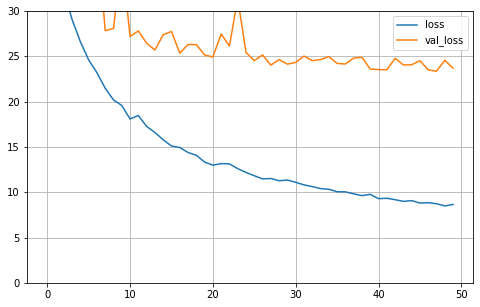

In [37]:
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,30)
plt.show()

# try probability model

In [27]:
# read in female data
result = pyreadr.read_r('/mnt/ML_HBLUP/NA_RM105_110_115/data/astProb_female.rds') # also works for RData
# done! 
# result is a dictionary where keys are the name of objects and the values python
# objects. In the case of Rds there is only one object with None as key
femaleData = result[None] # extract the pandas data frame 

# read in male data
result = pyreadr.read_r('/mnt/ML_HBLUP/NA_RM105_110_115/data/astProb_male.rds') # also works for RData
maleData = result[None] # extract the pandas data frame 

In [28]:
# add suffix
femaleData.columns += '_f'
maleData.columns += '_m'

In [29]:
# construct haplotype data for test and train data
trainHap = pd.concat([femaleData.loc[trainPheno['FEMALE'],:].reset_index(drop=True),
                      maleData.loc[trainPheno['MALE'],:].reset_index(drop=True)],axis=1)
trainHap = trainHap / 2

testHap = pd.concat([femaleData.loc[testPheno['FEMALE'],:].reset_index(drop=True),
                     maleData.loc[testPheno['MALE'],:].reset_index(drop=True)],axis=1)
testHap = testHap / 2

In [30]:
print(trainHap.shape)
print(testHap.shape)

(33475, 109598)
(7307, 109598)


In [31]:
trainHap.head()

,HB1__1067-1_f,HB1__32843_f,HB1__64DWA2_f,HB1__B73_f,HB1__MANS_f,HB1__NA_f,HB1__WDAQ2_f,HB2__1067-1_f,HB2__32843_f,HB2__64DWA2_f,...,HB17114__OH07_m,HB17114__PH207_m,HB17115__LH123_m,HB17115__NA_m,HB17115__OH07_m,HB17115__TA1180_m,HB17116__LH123_m,HB17116__NA_m,HB17116__OH07_m,HB17116__PH207_m
0,0.0,0.0,0.0,0.49665,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.00000,0.49975,0.0,0.0,0.00000,0.49965,0.0,0.00000
1,0.5,0.0,0.0,0.00000,0.0,0.0,0.0,0.5,0.0,0.0,...,0.0,0.48405,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.48175
2,0.0,0.0,0.0,0.00000,0.0,0.5,0.0,0.0,0.0,0.0,...,0.0,0.46920,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.46515
3,0.0,0.0,0.0,0.00000,0.0,0.5,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.00000
4,0.0,0.0,0.0,0.00000,0.0,0.5,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.49055,0.00000,0.0,0.0,0.48965,0.00000,0.0,0.00000


In [32]:
# splite the train data into train, validationa and test
seed = 20230510
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(trainHap, trainPheno['YLD_BE_BLUP'], test_size=0.1, random_state=seed)

seed = 20230515
np.random.seed(seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

In [33]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(24101, 109598)
(6026, 109598)
(3348, 109598)


In [34]:
del trainHap; del result; del femaleData; del maleData

In [35]:
gbm.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='mse',
        callbacks=[lgb.early_stopping(5)])

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[900]	valid_0's l2: 21.6143


LGBMRegressor(bagging_fraction=0.7, feature_fraction=0.5, learning_rate=0.05,
              n_estimators=900, num_leaves=20, objective='regression')

In [36]:
pred_train = gbm.predict(X_train)
pred_val = gbm.predict(X_val)
pred_test = gbm.predict(X_test)

rmse_train = mean_squared_error(y_train, pred_train, squared=False)
rmse_val = mean_squared_error(y_val,pred_val, squared=False)
rmse_test = mean_squared_error(y_test, pred_test, squared=False)

corr_train, p_value_train = pearsonr(y_train.ravel(), pred_train.ravel())
corr_val, p_value_val = pearsonr(y_val.ravel(), pred_val.ravel())
corr_test, p_value_test = pearsonr(y_test.ravel(), pred_test.ravel())

metrics_curr_cv = pd.DataFrame(data={'Method': 'LightGBM_hapProb', 'RMSE_train': [rmse_train], 'corr_train': [corr_train],
                                     'RMSE_val' : [rmse_val], 'corr_val' : [corr_val], 
                                     'RMSE_test' : [rmse_test], 'corr_test' : [corr_test]})

metrics = pd.concat([metrics, metrics_curr_cv], axis=0)
metrics

,Method,RMSE_train,RMSE_val,RMSE_test,corr_train,corr_val,corr_test
0,LightGBM_hapCat,3.469137,4.777890,4.667197,0.961032,0.925883,0.927294
0,LightGBM_hapProb,3.173386,4.649113,4.526483,0.967551,0.929793,0.931678


In [37]:
# save model
gbm.booster_.save_model('/mnt/ML_HBLUP/NA_RM105_110_115/models/lgbr_hapProb_20_900.txt')

# load model later
    #model = lightgbm.Booster(model_file='file.txt')
    #model.predict(predict[num_columns])

In [39]:
# predict 2021 test blup
pred_2021 = gbm.predict(testHap)
rmse_2021 = mean_squared_error(testPheno['YLD_BE_BLUP'], pred_2021, squared=False)
corr_2021, p_value_2021 = pearsonr(testPheno['YLD_BE_BLUP'].ravel(), pred_2021.ravel())


In [40]:
print(rmse_2021)
print(corr_2021)

18.195141085398273
0.10279315746934109
